**Título: Lab2**

**Membros da Equipe do Projeto:**
    
    - Pedro Ulisses 
    
    - Iago Jacob

Primeiramente, importando os módulos que serão utilizados:

In [6]:
## Este módulo é para trabalhar os datasets, neste caso de imagens, com a unidade fundamental dos tensores
import torch

## Esse submódulo de torch é para criar o dataset a partir de uma pasta no computador e depois carregá-lo
from torch.utils.data import Dataset, DataLoader

## Estes módulo é para realizar transformações sobre as imagens
import torchvision.transforms as transforms
from PIL import Image

## Este módulo permite a leitura de arquivos no python e operações com caminhos
import os

## Estes módulos são as redes neurais, já treinadas, que utilizaremos para gerar características para as imagens do dataset
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import resnet50, ResNet50_Weights


## Estes módulos serão utilizados para selecionar os melhores atributos para o posterior treino da AM
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


## Estes módulos serão utilizados para criar as figuras com os boxplots
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

As redes neurais utilizadas foram:

uwu

padrão do diretório foi

In [ ]:
## Este objeto transform é uma pipeline de ações para padronizar o tipo de imagem do nosso dataset, retornando tensores do torch ao final
transform = transforms.Compose([
    transforms.Resize(256),         
    transforms.CenterCrop(224),  
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


## Classe criada para realizar criar o dataset a partir dos caminhos fornecidos na máquina onde este código é rodado
class TxtFileDataset(Dataset):
    def __init__(self, txt_file, root_dir, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        self.image_paths_and_labels = []

        with open(txt_file, 'r') as f:
            for line in f:
                # Divide cada linha em uma lista com o caminho e com o rótulo, respectivamente
                line = line.strip()
                if line:
                    path, label = line.split()
                    self.image_paths_and_labels.append((path, int(label)))

    def __len__(self):
        # Retorna o número total de amostras no dataset
        return len(self.image_paths_and_labels)

    def __getitem__(self, idx):
        ## Será útil para situações em que precisaremos fazer dataset[idx]

        relative_path, label = self.image_paths_and_labels[idx]
        
        full_image_path = os.path.join(self.root_dir, relative_path)
        
        # Carrega a imagem usando a biblioteca Pillow (PIL)
        # .convert('RGB') garante que a imagem tenha 3 canais
        image = Image.open(full_image_path).convert('RGB')

        # Aplica as transformações na imagem, se houver
        if self.transform:
            image = self.transform(image)

        return image, label


caminho_arquivo_txt = f'.{os.sep}Dados{os.sep}train.txt'        # caminho para train.txt
diretorio_raiz_dados = f'.{os.sep}Dados'                        # caminho para o diretório de Dados


## Criação do dataset
dataset_train = TxtFileDataset(txt_file=caminho_arquivo_txt,
                             root_dir=diretorio_raiz_dados,
                             transform=transform)

## Estabelece-se que será utilizada a CPU para os processos com as redes neurais
device = torch.device("cpu")

## Para obtermos um processamento mais rápido, rodaremos as redes neurais em lotes de 16 imagens
batch_size = 16

data_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

################################################################### 

## Aqui, escolhemos a rede neural que será utilizada

#resnet = resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
resnet = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)

################################################################### 


## Estabelecemos que não iremos treinar a rede, mas testá-la, avaliá-la, tomando o seu tensor intermediário logo antes da classificação final
resnet.eval()
extracted_features = []

## Definimos a função hook para extrair o tensor intermediário do processo das redes neurais

def hook_fn(module, input, output):
    extracted_features.append(output.detach().cpu())


# Registrando o hook na camada 'avgpool'(camada antes da camada de classificação)
hook_handle = resnet.avgpool.register_forward_hook(hook_fn)
all_labels = []


## Aplicação da rede neural sobre as imagens no dataset já carregado
with torch.no_grad():
    for images, labels in data_loader:
        images = images.to(device)
        _ = resnet(images)
        all_labels.append(labels)

## Ajuste da dimensão dos tensores que guardam o resultado intermediário das redes neurais quando alimentadas com o dataset
features = torch.cat(extracted_features, dim=0)
features = features.view(features.size(0), -1)
labels = torch.cat(all_labels)

## Salvando os resultados obtidos para acessá-los diretamente depois
torch.save({
    'features': features,
    'labels': labels
}, 'resnet50_data.pt')


print("Features extraídas:", features.shape) # Deve ser [170, 512] ou [170, 2048], a depender da rede neural
print("Labels:", labels.shape) # [170]
hook_handle.remove()


Features extraídas: torch.Size([170, 2048])
Labels: torch.Size([170])


Realizando-se a seleção dos cinco atributos mais importantes:

In [8]:
# Carrega o dicionário salvo previamente salvo em arquivo
dados_carregados = torch.load('resnet50_data.pt')

# Acessa os tensores usando as mesmas chaves
features = dados_carregados['features']
labels = dados_carregados['labels']

# Feature extraction
test = SelectKBest(score_func=chi2,k=5)
fit = test.fit(features, labels)
features = fit.transform(features)
labels = labels.numpy()


## Salvando os resultados obtidos, já no formato de array numpy, para acessá-los diretamente depois
torch.save({
    'features': features,
    'labels': labels
}, 'select_data_np.pt')


print("Features extraídas:", features.shape) # Deve ser (170, 5)
print("Labels:", labels.shape) # 170


Features extraídas: (170, 5)
Labels: (170,)


Definindo uma função que gera o box plot para qualquer uma das quatro features:

In [9]:
# Carrega o dicionário salvo previamente salvo em arquivo
dados_carregados = torch.load('select_data_np.pt', weights_only=False)

# Carrega os arrays numpy
features = dados_carregados['features']
labels = dados_carregados['labels']

def criar_box_plot(idx):
    feature_a_plotar = features[:, idx]

    # Dataframe do pandas com duas colunas: uma para os valores da feature e outra para os rótulos.
    df = pd.DataFrame({
        'feature_value': feature_a_plotar,
        'label': labels
    })

    plt.figure(figsize=(10, 6))

    sns.boxplot(x='label', y='feature_value', data=df)

    plt.title(f'Boxplot da Feature {idx} para cada Classe')
    plt.xlabel('Classe (Label)')
    plt.ylabel(f'Valor da Feature {idx}')
    plt.grid(True) # Adiciona uma grade para facilitar a leitura
    plt.show()

Para índices de 0 a 4:

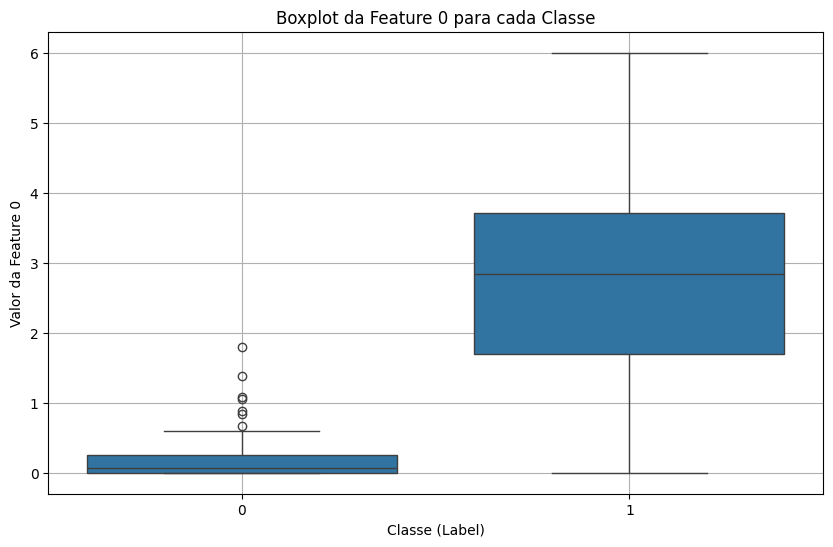

In [10]:
criar_box_plot(0)

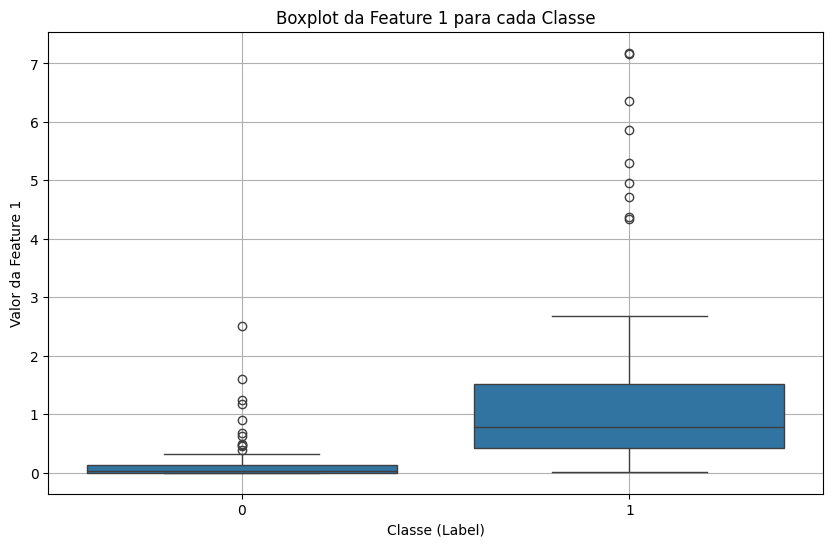

In [11]:
criar_box_plot(1)

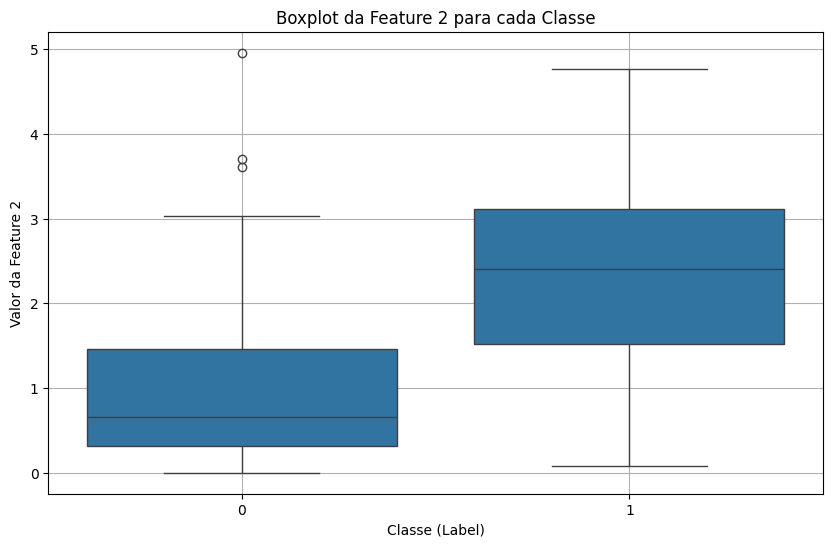

In [12]:
criar_box_plot(2)

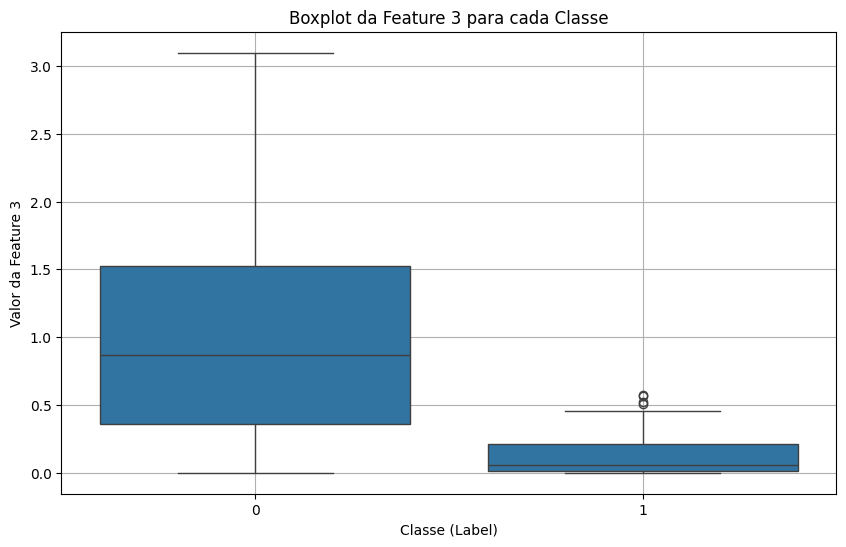

In [13]:
criar_box_plot(3)

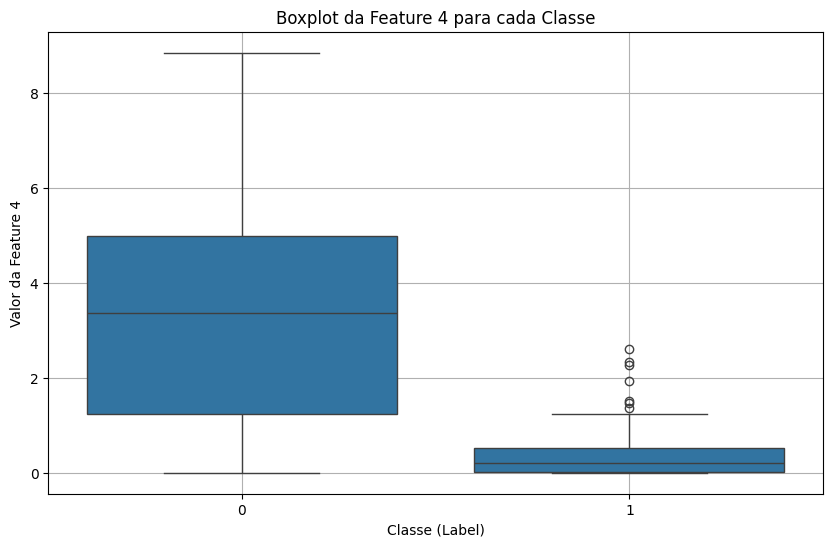

In [14]:
criar_box_plot(4)

**Modelagem**


2. Treinamento dos modelos
a) kNN
b) AD
c) RF
3. Teste dos modelos
4. Discussões
5. Conclusões: Comentários e sugestões sobre o trabalho
(complexidade/facilidade, sugestões, etc.).
